# DML Diff-in-Diff


In [1]:
import numpy as np
import pandas as pd
import doubleml as dml
import multiprocessing
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from xgboost import XGBClassifier, XGBRegressor


We will focus on the the Ddata generating processes from [Sant'Anna and Zhao (2020)](https://arxiv.org/abs/1812.01723), see Section 4.1 and 4.2.

In [2]:
def f_reg(W):
  res = 210 + 27.4*W[:, 0] + 13.7*(W[:, 1] + W[:, 2] + W[:, 3])
  return res

def f_ps(W):
  res = 0.75*(-W[:, 0] + 0.5*W[:, 1] - 0.25*W[:, 2] - 0.1*W[:, 3])
  return res

def dgp(n=200, dgp_type=1):
  # features
  X = np.random.normal(loc=0, scale=1, size=[n,4])
  Z_tilde_1 = np.exp(0.5*X[:, 0])
  Z_tilde_2 = 10 + X[:, 1] / (1 + np.exp(X[:, 0]))
  Z_tilde_3 = (0.6 + X[:, 0]*X[:, 2]/25)**3
  Z_tilde_4 = (20 + X[:, 1] + X[:, 3])**2

  Z_tilde = np.column_stack((Z_tilde_1, Z_tilde_2, Z_tilde_3, Z_tilde_4))
  Z = (Z_tilde - np.mean(Z_tilde, axis=0)) / np.std(Z_tilde, axis=0)
  
  # error terms
  epsilon_0 = np.random.normal(loc=0, scale=1, size=n)
  epsilon_1 = np.random.normal(loc=0, scale=1, size=[n,2])
  if dgp_type == 1:
    features_ps = Z
    features_reg = Z
  elif dgp_type == 2:
    features_ps = X
    features_reg = Z
  elif dgp_type == 3:
    features_ps = Z
    features_reg = X
  elif dgp_type == 4:
    features_ps = X
    features_reg = X
  elif dgp_type == 5:
    features_reg = Z
  elif dgp_type == 6:
    features_reg = X

  # treatment and propensities
  if (dgp_type == 5) or (dgp_type == 6):
    # Set D to be experimental
    p = 0.5*np.ones(n)
  else:
    p = np.exp(f_ps(features_ps)) / (1 + np.exp(f_ps(features_ps)))
  U = np.random.uniform(low=0, high=1, size=n)
  D = 1.0 * (p >= U)

  # potential outcomes
  nu =  np.random.normal(loc=D*f_reg(features_reg), scale=1, size=n)
  Y0 = f_reg(features_reg) + nu + epsilon_0
  Y1_d0 = 2*f_reg(features_reg) + nu + epsilon_1[:, 0]
  Y1_d1 = 2*f_reg(features_reg) + nu + epsilon_1[:, 1]
  Y1 = D*Y1_d1 + (1-D)*Y1_d0

  return Y0, Y1, D, Z, Y1_d0, Y1_d1


The ATT should be zero. We will check this numerically:

In [3]:
dgp_types = [1, 2, 3, 4, 5, 6]
n_dgps = len(dgp_types)

for dgp_type in dgp_types:  
    _, _, D, _, Y1_d0, Y1_d1 = dgp(int(10e+6), dgp_type=dgp_type)
    ATT = np.mean(Y1_d1[D == 1] - Y1_d0[D == 1])
    print(f'ATT (DGP={dgp_type}): {ATT}')
# Set the true ATT to zero
ATT = 0

ATT (DGP=1): 0.00023038857684221954
ATT (DGP=2): 6.162554689342382e-05
ATT (DGP=3): -0.00036540829122854704
ATT (DGP=4): -9.095250947683425e-05
ATT (DGP=5): -0.00042058080856606554
ATT (DGP=6): 0.0008005161683887945


In [4]:
np.random.seed(42)
n_rep = 500
n_obs = 1000
lambda_T = 0.5

datasets = []
for dgp_type in dgp_types:
    datasets_dgp = []
    for i in range(n_rep):
        Y0, Y1, D, X, _, _ = dgp(n=n_obs, dgp_type=dgp_type)

        # datasets with repeated cross sections
        U_T = np.random.uniform(low=0, high=1, size=n_obs)
        T = 1.0 * (U_T <= lambda_T)
        Y_obs = T * Y1 + (1-T)*Y0
        data = dml.DoubleMLDIDData.from_arrays(X, Y_obs, D, T)
        datasets_dgp.append(data)
    datasets.append(datasets_dgp)

In [5]:
n_estimators = 200

# Random Forest
# ml_g = RandomForestRegressor(n_estimators=n_estimators)
# ml_m = RandomForestClassifier(n_estimators=n_estimators)

# Boosted Trees
ml_g = XGBRegressor(n_jobs=1, objective = "reg:squarederror",
                    eta=0.1, n_estimators=n_estimators)
ml_m = XGBClassifier(n_jobs=1, objective = "binary:logistic",
                     eval_metric = "logloss",
                     eta=0.1, n_estimators=n_estimators)

# linear models
#ml_g = LinearRegression()
#ml_m = LogisticRegression()

n_cores = multiprocessing.cpu_count()
print(f"Number of Cores: {n_cores}")
# to be process folds in parallel
cores_used = 5

Number of Cores: 8


## Repeated Cross-sectional Data

Use the same data with coss-sectional observations

In [6]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [7]:
score_names = ["Zimmert (efficient)", "Zimmert (not efficient)","Zimmert (experimental)", "Sant'Anna (efficient)","Sant'Anna (not efficient)","Chang"]
valid_scores = ['CS-4', 'CS*-4', 'CS-5', 'DR-2', 'DR-1']
n_scores = len(valid_scores)
coefs = np.full((n_rep, n_dgps, n_scores+1), np.nan)
ses = np.full((n_rep, n_dgps, n_scores+1), np.nan)
cover = np.full((n_rep, n_dgps, n_scores+1), np.nan)
ci_length = np.full((n_rep, n_dgps, n_scores+1), np.nan)

for i_dgp, dgp_type in enumerate(dgp_types):
    print(f'DPG={dgp_type}')
    for i_rep in range(n_rep):
        if (i_rep % int(n_rep/10)) == 0:
            print(f'Iteration: {i_rep}/{n_rep}')
        obj_dml_data = datasets[i_dgp][i_rep]
        with suppress_stdout():
            for i_score, score in enumerate(valid_scores):
                dml_DiD = dml.DoubleMLDiDCS(obj_dml_data,
                                            ml_g=clone(ml_g),
                                            ml_m=clone(ml_m),
                                            score=score,
                                            n_folds=5)
                dml_DiD.fit(n_jobs_cv=cores_used)
                # save coefs and ses
                coefs[i_rep, i_dgp, i_score] = dml_DiD.coef
                ses[i_rep, i_dgp, i_score] = dml_DiD.se

                # calculate confidence interval
                confint = dml_DiD.confint(level=0.95)
                cover[i_rep, i_dgp, i_score] = (confint['2.5 %'] < ATT) & (ATT < confint['97.5 %'])
                ci_length[i_rep, i_dgp, i_score] = confint['97.5 %'] - confint['2.5 %']
            
            # estimate ATT with Chang
            dml_DiD_ch = dml.DoubleMLDID(obj_dml_data,
                                        ml_g=clone(ml_g),
                                        ml_m=clone(ml_m),
                                        score='RCS',
                                        n_folds=5)

            dml_DiD_ch.fit(n_jobs_cv=cores_used)
            # save coefs and ses
            coefs[i_rep, i_dgp, n_scores] = dml_DiD_ch.coef
            ses[i_rep, i_dgp, n_scores] = dml_DiD_ch.se

            # calculate confidence interval
            confint = dml_DiD_ch.confint(level=0.95)
            cover[i_rep, i_dgp, n_scores] = (confint['2.5 %'] < ATT) & (ATT < confint['97.5 %'])
            ci_length[i_rep, i_dgp, n_scores] = confint['97.5 %'] - confint['2.5 %']
print('Finished!')

DPG=1
Iteration: 0/500
Iteration: 50/500
Iteration: 100/500
Iteration: 150/500
Iteration: 200/500
Iteration: 250/500
Iteration: 300/500
Iteration: 350/500
Iteration: 400/500
Iteration: 450/500
DPG=2
Iteration: 0/500
Iteration: 50/500
Iteration: 100/500
Iteration: 150/500
Iteration: 200/500
Iteration: 250/500
Iteration: 300/500
Iteration: 350/500
Iteration: 400/500
Iteration: 450/500
DPG=3
Iteration: 0/500
Iteration: 50/500
Iteration: 100/500
Iteration: 150/500
Iteration: 200/500
Iteration: 250/500
Iteration: 300/500
Iteration: 350/500
Iteration: 400/500
Iteration: 450/500
DPG=4
Iteration: 0/500
Iteration: 50/500
Iteration: 100/500
Iteration: 150/500
Iteration: 200/500
Iteration: 250/500
Iteration: 300/500
Iteration: 350/500
Iteration: 400/500
Iteration: 450/500
DPG=5
Iteration: 0/500
Iteration: 50/500
Iteration: 100/500
Iteration: 150/500
Iteration: 200/500
Iteration: 250/500
Iteration: 300/500
Iteration: 350/500
Iteration: 400/500
Iteration: 450/500
DPG=6
Iteration: 0/500
Iteration: 5

## Results

In [8]:
dpg_summary = []
for i_dgp, dgp_type in enumerate(dgp_types):
    data = {'Avg. Bias': coefs[:, i_dgp, :].mean(0),
            'RMSE': np.sqrt(np.square(coefs[:, i_dgp, :])).mean(0),
            'Asy. Variance': np.sqrt(n_obs)*np.square(ses[:, i_dgp, :]).mean(0),
            'Coverage': cover[:, i_dgp, :].mean(0),
            'Avg. CI length': ci_length[:, i_dgp, :].mean(0)}
    dpg_summary.append(pd.DataFrame(data, index=score_names))
print("Summary DGP=1")
dpg_summary[0]

Summary DGP=1


,Avg. Bias,RMSE,Asy. Variance,Coverage,Avg. CI length
Zimmert (efficient),1.488715,11.824763,9765.776427,0.982,60.261901
Zimmert (not efficient),-1.673356,28.205842,77293.748766,0.990,193.192476
Zimmert (experimental),-2.600389,3.671505,196.025483,0.720,9.722566
Sant'Anna (efficient),0.337129,7.214229,43594.737440,1.000,145.507349
Sant'Anna (not efficient),-0.164948,5.567265,11893.644793,1.000,75.928123
Chang,-0.437335,16.176389,55368.315380,1.000,160.510557


In [9]:
print("Summary DGP=2")
dpg_summary[1]

Summary DGP=2


,Avg. Bias,RMSE,Asy. Variance,Coverage,Avg. CI length
Zimmert (efficient),1.408455,14.786821,13471.317439,0.980,73.404892
Zimmert (not efficient),0.644978,30.155969,81786.929217,0.988,198.649937
Zimmert (experimental),-1.649333,3.274956,216.769873,0.790,10.210223
Sant'Anna (efficient),-0.114912,7.438985,45352.180116,1.000,148.400549
Sant'Anna (not efficient),-0.634785,5.676163,12425.357100,1.000,77.607699
Chang,0.878526,17.773622,67746.872908,1.000,177.903997


In [10]:
print("Summary DGP=3")
dpg_summary[2]

Summary DGP=3


,Avg. Bias,RMSE,Asy. Variance,Coverage,Avg. CI length
Zimmert (efficient),0.926922,12.545489,10076.660202,0.980,64.881504
Zimmert (not efficient),1.825209,29.030963,76652.330177,0.996,192.594740
Zimmert (experimental),-1.243968,2.773398,242.689281,0.862,10.848929
Sant'Anna (efficient),-0.366264,7.290832,43973.981923,1.000,146.148756
Sant'Anna (not efficient),-0.094955,5.599543,11963.803009,1.000,76.184212
Chang,-0.656091,16.229287,53301.972324,1.000,158.352347


In [11]:
print("Summary DGP=4")
dpg_summary[3]

Summary DGP=4


,Avg. Bias,RMSE,Asy. Variance,Coverage,Avg. CI length
Zimmert (efficient),7.799412,18.314257,18370.029941,0.972,86.366427
Zimmert (not efficient),7.015450,30.374447,84342.528472,0.996,201.531786
Zimmert (experimental),-2.651444,3.540100,245.308332,0.768,10.907446
Sant'Anna (efficient),-0.252513,8.381179,43194.181391,1.000,144.818641
Sant'Anna (not efficient),-0.289769,6.788975,12217.100699,1.000,76.925673
Chang,7.317018,20.098991,71264.874588,1.000,182.199988


In [12]:
print("Summary DGP=5")
dpg_summary[4]

Summary DGP=5


,Avg. Bias,RMSE,Asy. Variance,Coverage,Avg. CI length
Zimmert (efficient),-1.372960,8.992168,4579.706798,0.960,41.408935
Zimmert (not efficient),-0.949905,29.266472,76485.879234,0.996,192.642176
Zimmert (experimental),-0.120967,2.141420,231.473910,0.946,10.557055
Sant'Anna (efficient),-0.297218,7.566776,47334.542480,1.000,151.618329
Sant'Anna (not efficient),0.100016,5.565372,12863.713970,1.000,78.765608
Chang,-0.964848,15.148912,33948.299677,1.000,125.807574


In [13]:
print("Summary DGP=6")
dpg_summary[5]

Summary DGP=6


,Avg. Bias,RMSE,Asy. Variance,Coverage,Avg. CI length
Zimmert (efficient),-1.181883,8.331921,4169.201468,0.960,40.658043
Zimmert (not efficient),-0.885463,29.218310,75900.664116,0.996,191.937187
Zimmert (experimental),-0.139680,2.318050,255.846675,0.944,11.139490
Sant'Anna (efficient),0.351376,7.040528,46950.353041,1.000,151.013259
Sant'Anna (not efficient),0.409057,4.961399,12348.584670,1.000,77.427141
Chang,-0.558442,13.822943,31070.850765,1.000,121.412401


In [14]:
df_plot_dens = pd.DataFrame(data=None, columns=['DGP', 'Algorithm', 'ATT'])
df_plot_cov = pd.DataFrame(data=None, columns=['DGP', 'Algorithm', 'Coverage'])
for i_dgp, dgp_type in enumerate(dgp_types):
    for i_score, score in enumerate(score_names):
        # add ATT estimates for density plot
        df = pd.DataFrame(coefs[:, i_dgp, i_score], columns=['ATT'])
        df['DGP'] = str(dgp_type)
        df['Algorithm'] = score
        df_plot_dens = pd.concat([df_plot_dens, df], axis=0)

        #add coverage data
        df = pd.DataFrame(np.array([[cover[:, i_dgp, i_score].mean()]]), columns=["Coverage"])
        df['DGP'] = str(dgp_type)
        df['Algorithm'] = score
        df_plot_cov = pd.concat([df_plot_cov, df], axis=0)

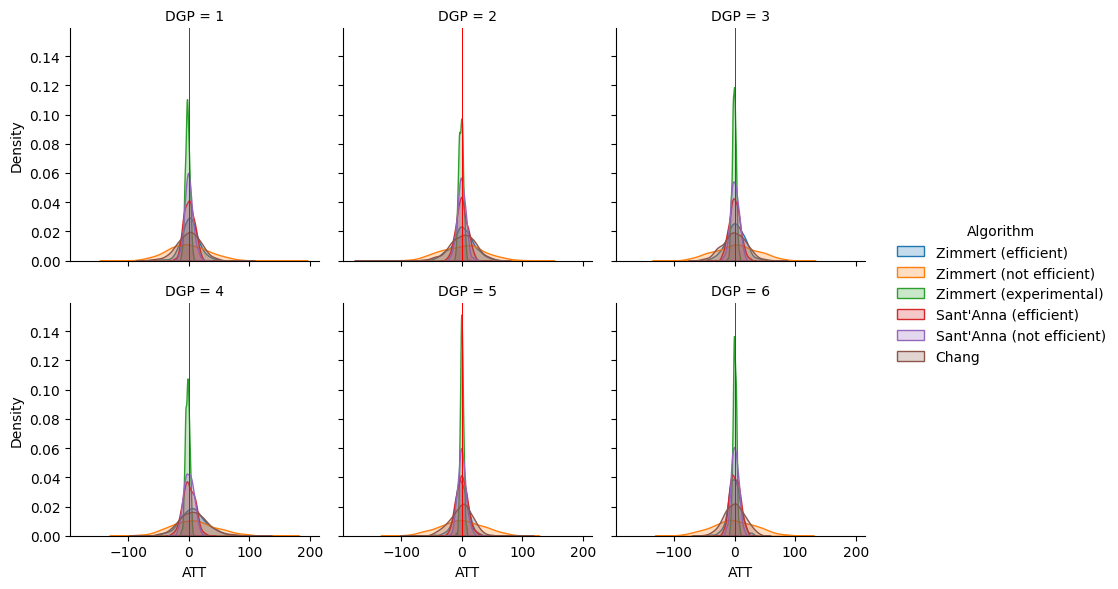

In [15]:
g = sns.FacetGrid(df_plot_dens, col="DGP", hue="Algorithm", col_wrap=3)
g.map_dataframe(sns.kdeplot, x="ATT", fill=True)
g.add_legend()
g.map(plt.axvline, x=ATT, ls='-', c='red', lw=0.5)

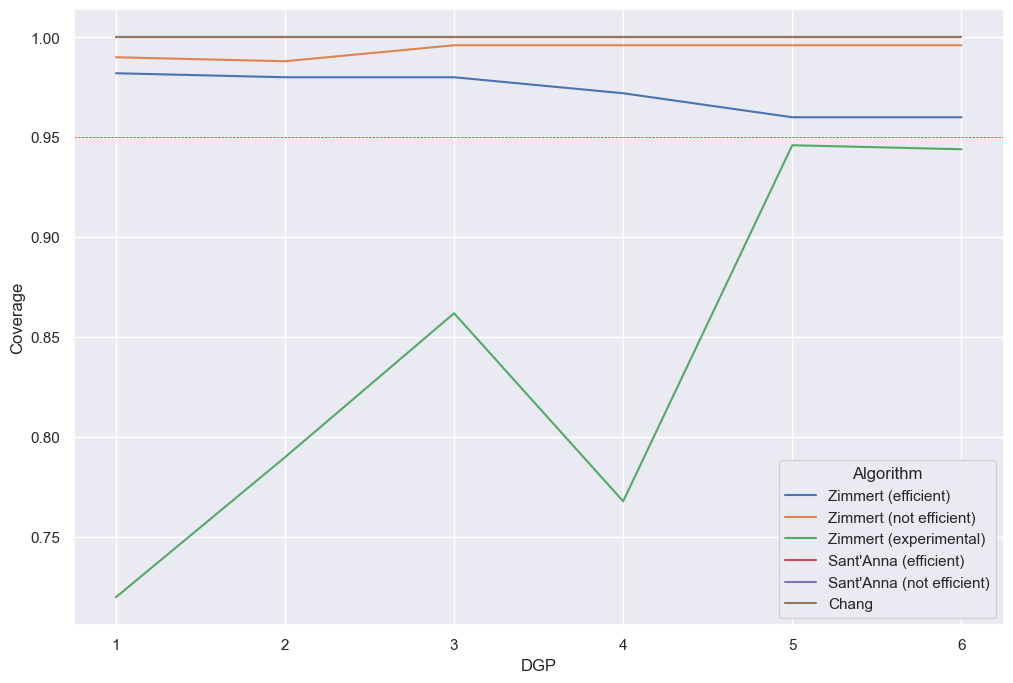

In [16]:
sns.set(rc={'figure.figsize':(12,8)})
g = sns.lineplot(data=df_plot_cov, x="DGP", y="Coverage", hue="Algorithm")
g.axhline(0.95, ls='--', c='red', lw=0.5)